In [2]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [24]:
from sklearn.tree import DecisionTreeRegressor

In [7]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"
data = pd.read_csv(DATA_PATH  + "winequality-white.csv", sep=";")

In [8]:
df = data

In [9]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [10]:
y = df["quality"]
df_features = df.drop(columns=['quality'])
df_features.head()
X_train, X_holdout, y_train, y_holdout = train_test_split(df_features, y, test_size = 0.3, random_state = 17)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)

In [11]:
X_train_scaled

array([[-0.99273   ,  0.58375489,  2.64116886, ..., -0.32100149,
         0.10300887, -1.41119853],
       [-0.41141461,  0.38747125, -0.84407222, ..., -0.05551066,
        -0.25313273, -0.51729161],
       [ 0.16990079,  0.28932942,  1.50643921, ..., -0.78561044,
        -0.52023894, -0.11097029],
       ...,
       [-1.22525616, -0.00509605,  0.04750108, ...,  1.33831618,
        -0.87638054,  1.83937207],
       [ 2.72768852, -0.49580516,  0.1285532 , ..., -0.65286502,
        -1.49962834, -0.67982014],
       [-1.10899308,  0.1911876 , -0.27670739, ...,  1.47106159,
        -0.69830974,  1.92063633]])

In [15]:
y_train.head()

96      6
2292    6
1054    5
3687    5
596     5
Name: quality, dtype: int64

In [40]:
def pseudo_residuals(y_train):
    resid = y_train.copy()
    mean = y_train.mean()
    for res in range(len(resid)):
       resid.iloc[res] = resid.iloc[res] - mean
    return resid

96      0.123104
2292    0.123104
1054   -0.876896
3687   -0.876896
596    -0.876896
          ...   
2800   -0.876896
1337   -0.876896
406     1.123104
2191   -0.876896
2671    1.123104
Name: quality, Length: 3428, dtype: float64


In [72]:
def weight_train(y, x, M):
    forest_tree = []
    mean = y.mean()
    resid = pseudo_residuals(y_train)
    forest_tree.append(mean)
    last_resid = resid.copy()
    for i in range(M):
        current_tree = DecisionTreeRegressor(max_depth=10, random_state=42, min_samples_leaf=2)
        resid = pseudo_residuals(last_resid)
        last_resid = resid.copy()
        current_tree.fit(x, last_resid)
        forest_tree.append(current_tree)
    return forest_tree
forest_tree = weight_train(y_train, X_train, 3)


In [119]:
def prediction_results(x_test, y_holdout, forest_tree, learning_rate_):
    learning_rate = learning_rate_
    y_res = y_holdout.copy()
    for res in range(len(y_res)):
       y_res.iloc[res] = forest_tree[0]
    for i in range(1, len(forest_tree)):
        y_res = list(map(sum, zip(y_res, learning_rate * forest_tree[i].predict(x_test)))) 
    return y_res

y_pred = prediction_results(X_holdout, y_holdout, forest_tree, 0.1)

In [120]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(y_holdout, y_pred)
print(error)

0.6078027705715042


[Text(0.5, 0.75, 'x[10] <= 10.85\nsquared_error = 0.786\nsamples = 3428\nvalue = 5.877'),
 Text(0.25, 0.25, 'squared_error = 0.584\nsamples = 2142\nvalue = 5.595'),
 Text(0.75, 0.25, 'squared_error = 0.772\nsamples = 1286\nvalue = 6.346')]

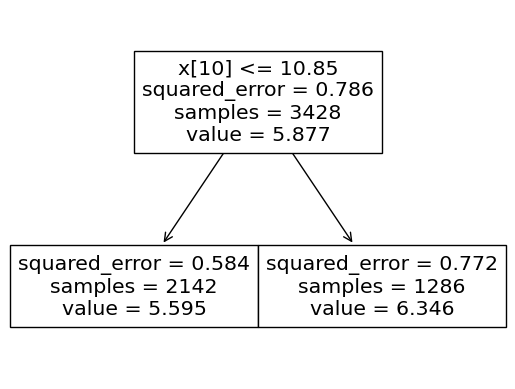

In [51]:
from sklearn import tree
current_tree = DecisionTreeRegressor(max_depth=1, random_state=42)
pred=current_tree.fit(X_train, y_train)
len(current_tree.tree_.value)
tree.plot_tree(pred)

In [64]:
n = current_tree.tree_.value[2]
n = np.resize(n, (1))
n[0]

6.346034214618974

In [112]:
yres1 = current_tree.predict(X_holdout)
current_tree2 = DecisionTreeRegressor(max_depth=1, random_state=42)
current_tree2.fit(X_train, y_train)
yres2 = current_tree2.predict(X_holdout)
c = list(map(sum, zip(yres1, yres2)))

print(c)

[11.19047619047619, 12.692068429237947, 11.19047619047619, 12.692068429237947, 11.19047619047619, 11.19047619047619, 12.692068429237947, 11.19047619047619, 11.19047619047619, 11.19047619047619, 12.692068429237947, 12.692068429237947, 11.19047619047619, 11.19047619047619, 12.692068429237947, 11.19047619047619, 11.19047619047619, 12.692068429237947, 11.19047619047619, 12.692068429237947, 11.19047619047619, 12.692068429237947, 11.19047619047619, 11.19047619047619, 12.692068429237947, 11.19047619047619, 11.19047619047619, 12.692068429237947, 11.19047619047619, 11.19047619047619, 11.19047619047619, 11.19047619047619, 12.692068429237947, 11.19047619047619, 11.19047619047619, 11.19047619047619, 12.692068429237947, 11.19047619047619, 12.692068429237947, 11.19047619047619, 11.19047619047619, 11.19047619047619, 12.692068429237947, 12.692068429237947, 11.19047619047619, 12.692068429237947, 12.692068429237947, 12.692068429237947, 11.19047619047619, 12.692068429237947, 11.19047619047619, 11.1904761

In [151]:
from sklearn.model_selection import GridSearchCV

class GradientBoosting():
    def __init__(self, learning_rate_, iter_,):
        self.parameters={"max_depth" : [11,12, 15, 16, 17, 18],
        "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10]}
        self.learning_rate = learning_rate_
        self.iter = iter_
        self.forest_tree_ = []
        self.pred = []
    
    def get_pred(self):
        return self.pred
    
    def fit_(self, x, y):
        forest_tree = []
        mean = y.mean()
        resid = pseudo_residuals(y_train)
        forest_tree.append(mean)
        last_resid = resid.copy()
        for i in range(self.iter):
            current_tree = DecisionTreeRegressor(random_state=42)
            tuning_model=GridSearchCV(current_tree, param_grid=self.parameters,scoring='mean_squared_error',cv=3,verbose=3)
            tuning_model.fit(x, last_resid)
            params = tuning_model.best_params_
            resid = pseudo_residuals(last_resid)
            last_resid = resid.copy()
            new_current_tree = DecisionTreeRegressor(max_depth=params["max_depth"],
                                                    min_samples_leaf=params["min_samples_leaf"],
                                                    random_state=42)
            new_current_tree.fit(x, last_resid)
            forest_tree.append(new_current_tree)
            self.forest_tree_ = forest_tree
    
    def predict(self, x_test, y_holdout):
        y_res = y_holdout.copy()
        for res in range(len(y_res)):
            y_res.iloc[res] = self.forest_tree_[0]
        for i in range(1, len(self.forest_tree_)):
            y_res = list(map(sum, zip(y_res, self.learning_rate * self.forest_tree_[i].predict(x_test)))) 
        self.pred = y_res

    def valid(hold):
        return mean_squared_error(hold, self.pred)

In [154]:
gb = GradientBoosting(0.1, 40)
gb.fit_(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV 1/3] END .max_depth=11, min_samples_leaf=1;, score=-0.709 total time=   0.0s
[CV 2/3] END .max_depth=11, min_samples_leaf=1;, score=-0.713 total time=   0.0s
[CV 3/3] END .max_depth=11, min_samples_leaf=1;, score=-0.682 total time=   0.0s
[CV 1/3] END .max_depth=11, min_samples_leaf=2;, score=-0.664 total time=   0.0s
[CV 2/3] END .max_depth=11, min_samples_leaf=2;, score=-0.684 total time=   0.0s
[CV 3/3] END .max_depth=11, min_samples_leaf=2;, score=-0.662 total time=   0.0s
[CV 1/3] END .max_depth=11, min_samples_leaf=3;, score=-0.637 total time=   0.0s
[CV 2/3] END .max_depth=11, min_samples_leaf=3;, score=-0.649 total time=   0.0s
[CV 3/3] END .max_depth=11, min_samples_leaf=3;, score=-0.638 total time=   0.0s
[CV 1/3] END .max_depth=11, min_samples_leaf=4;, score=-0.629 total time=   0.0s
[CV 2/3] END .max_depth=11, min_samples_leaf=4;, score=-0.588 total time=   0.0s
[CV 3/3] END .max_depth=11, min_samples_leaf=4;

In [158]:
gb.predict(X_holdout, y_holdout)
gb.get_pred()

[4.456268073664449,
 6.946234628848383,
 6.06161924423301,
 8.369311551925314,
 3.581432764046542,
 5.737732604556885,
 6.06161924423301,
 6.839899787219433,
 5.316679972977954,
 4.035978218591974,
 10.122397971678406,
 9.936879119492891,
 2.9619041445179044,
 5.835978218591971,
 6.946234628848383,
 5.569311551925334,
 5.835978218591971,
 10.122397971678406,
 9.36931155192531,
 8.820924455151122,
 5.737732604556885,
 9.480422663036418,
 2.083597266211037,
 2.061619244233015,
 6.869311551925324,
 6.849311551925335,
 1.5121686947824677,
 10.005675188288967,
 4.617245436222855,
 8.957546846042955,
 3.5121686947824697,
 2.005675188288952,
 5.527206288767419,
 5.226454409068178,
 4.456268073664449,
 6.839899787219433,
 6.005675188288964,
 5.734390917004684,
 5.226454409068178,
 2.061619244233015,
 7.702644885258645,
 4.456268073664449,
 11.460220642834397,
 7.169311551925335,
 1.9693115519253293,
 10.122397971678406,
 5.835978218591971,
 6.869311551925324,
 5.7693115519253295,
 6.9846961673

In [157]:
mean_squared_error(y_holdout, gb.get_pred())

5.31493392950287

In [160]:
y_holdout

1682    7
4181    6
1992    5
4239    7
600     6
       ..
2718    6
1128    5
66      7
3941    5
4671    5
Name: quality, Length: 1470, dtype: int64